# Structure of the code
1. Primodial gas
2. Mass life time relation
3. Stellar yields tables
4. IMF

# Some conventions
1. We consider the first 30 elements of the periodic table but the metallicity of the ejecta/wind is defined as $M_{\rm ini}-M_{\rm rem}-M_{\rm H}-M_{\rm He}$
2. The solar abundance tables in number are converted to in mass

   It refers to how much mass of each element per unit mass of hydrogen in the sun.
   The index of one item of `abund_tables` in the `constants.py` start from 1.
   For instance `abund_tables["Default"][2]` is how much mass of helium per unit mass of hydrogen in the `Default` table and 
   `abund_tables["Default"][0]` is set to 0.
3. Both the mass range of the IMF and the stellar yield tables is restricted to be $[0.08,150]~M_{\odot}$
   
   - If the minimum mass $M_{\rm min}$ of the IMF is larger than $0.08~M_{\odot}$, then the IMF in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero.
   - As is often the case, the $M_{\rm min}$ in the stellar yield tables is larger than $0.08~M_{\odot}$, so the yield in the range $[0.08,M_{\rm min}]~M_{\odot}$ is set to be zero, and the $M_{\rm max}$ in the stellar yield tables is smaller than $150~M_{\odot}$, so the yield in the range $[M_{\rm max},150]~M_{\odot}$ is set to be the same as that at $M_{\rm max}$. As for the $M_{\rm rem}$, it is set to be $M_{\rm ini}$ in the range $[0.08,M_{\rm min}]~M_{\odot}$ and we keep $M_{\rm ini}-M_{\rm rem}$ a constant in the range $[M_{\rm max},150]~M_{\odot}$.
   - The number of sampled mass points in the stellar yield tables are often just a few, so we will interpolate the yield tables to get the yield at any mass in the range $[0.08,150]~M_{\odot}$.

4. About the star formation history file

   - You should input the star formation history in a txt file with just two columns, the first column is the time in `yr` and the second column is the star formation rate in $M_{\odot}~{\rm yr}^{-1}$.
   - You can add as many lines of comments as you want in the header of the txt file, but the comments should be started with `#`, which is the default comment symbol in `np.loadtxt`.
   - The star formation rate in the last line (the last time) won't be used in the calculation of the chemical evolution, so you should set it to be zero.

5. Units

   - The default unit of mass is $M_{\odot}$.
   - The default unit of time is `yr`.

# About the IMF
The IMF in `IMF` class defined in `utils.py` is NORMALIZED to be $\int_{0.08}^{150} \xi(m)dm=1$.
Assuming $M_{\ast, i}$ and $N_{\mathrm{formed}, i}$ are the formed mass and number of stars in ith epoch, respectively:
$$
N_{\mathrm{formed}, i} = \frac{M_{\ast, i}}{\int_{0.08}^{150} m \xi(m)dm}
$$

$N_{\mathrm{formed}, i}$ should be an integer, but we will NOT round it to the nearest integer.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on April 23, 2024
Last modified on April 23, 2024
@Author: Guan-Fu Liu

To calculate how the abundance evolves with time with variable IMF
"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF')
import re
import os
import utils
import constants
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import time
%matplotlib widget

In [2]:
###### Load the yields table ######
yield_files = {
                "AGB+SNcc":"./inputs/NuPyCEE/isotope_yield_table_portinari98_marigo01_gce_totalyields/yields1.h5",
                "SNIa":"./inputs/NuPyCEE/sn1a_i99_W7/yields1.h5",
               }
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
ElemNotice = ["H", "He", "N", "O", "Ne", "Fe", "Other"] # The elements we are interested in
# They should appear in the yield table from AGB+SNcc.
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
dfs = { }
ElemIntersect = { }
for key in files.keys():
    dfs[key] = { }
    ElemIntersect[key] = { }
    for group in groups[key]:
        if key == "SNIa":
            dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
        else:
            dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
        dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
        dfs[key][group].set_index('M', inplace=True)
        index = dfs[key][group].index
        index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
        # Add the mass of the elements not in ElemNotice to the "Other" element
        if "Other" in dfs[key][group].index:
            dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
        else:
            dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
        ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))

###### Load the yields table ######

The elements you notice but not available in the yield table of SNIa, Z=0.02 are {'He', 'H'}


In [3]:
output_dir = "./outputs/"
solar_set = "Default"
f =  h5py.File(os.path.join(output_dir, "2024-05-05-21-39.h5"), 'r') 
GasElement = f['Gas/GasElement'][()]
SFH = { }
for key in ['Age', 'SFR', 'TimeBin', 'Mstar']:
    SFH[key] = f['Star/'+key][()]

YieldsTable = f['Gas/YieldsTable'][()]
f.close()

In [4]:
Zini = re.search(r"AGB\+SNcc: (.*?),", YieldsTable[0].astype(str)).group(1)

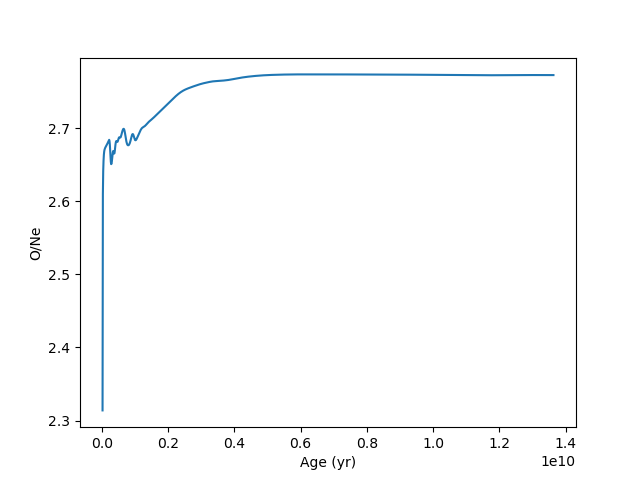

In [6]:
# Detailed model
mask = GasElement[:, constants.elem_names.index("Ne")]>0
y = GasElement[mask, constants.elem_names.index("O")]/GasElement[mask, constants.elem_names.index("Ne")]/O2Ne[solar_set]
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask], y, label='O/Ne')
ax.set_xlabel('Age (yr)')
ax.set_ylabel('O/Ne')
ax.set_title('Detailed model, Portinari et al. (1998) & Marigo (2001)')
plt.show()

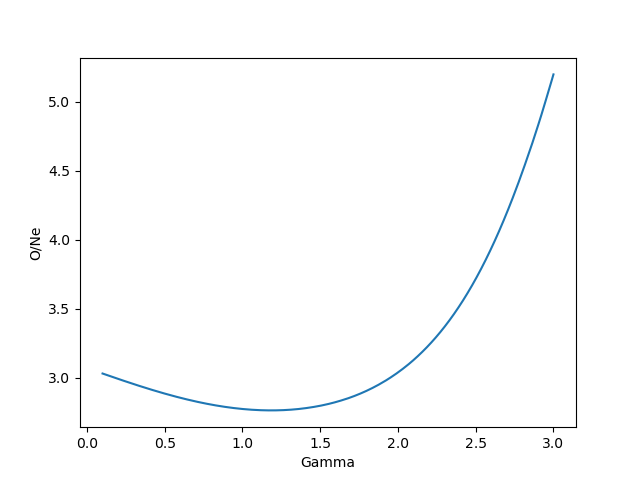

In [7]:
# From the yield table, toy model
x = dfs['AGB+SNcc'][Zini].columns.to_numpy().astype(np.float64)
y1 = dfs['AGB+SNcc'][Zini].loc['O'].to_numpy().astype(np.float64)
y2 = dfs['AGB+SNcc'][Zini].loc['Ne'].to_numpy().astype(np.float64)
interp1 = interpolate.interp1d(x, y1, kind='linear', fill_value='extrapolate')
interp2 = interpolate.interp1d(x, y2, kind='linear', fill_value='extrapolate')
mass_bound = utils.lifetime_to_mass(13e9, 0.002)
O2Ne = { }
O2Ne[solar_set] = constants.abund_tables[solar_set][constants.elem_names.index("O")]/\
    constants.abund_tables[solar_set][constants.elem_names.index("Ne")]

def PowerLaw(m, Gamma, interp):
    return m**(-Gamma-1)*interp(m)

Gammas = np.linspace(0.1, 3.0, 300)
Oxygen = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp1), full_output=1)[0] \
                   for Gamma in Gammas])
Neon = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp2), full_output=1)[0] \
                 for Gamma in Gammas])

fig, ax = plt.subplots()
ax.plot(Gammas, Oxygen/Neon/(O2Ne[solar_set]), label='O/Ne')
ax.set_xlabel('Gamma')
ax.set_ylabel('O/Ne')
ax.set_title('Toy model, Portinari et al. (1998) & Marigo (2001)')
plt.show()

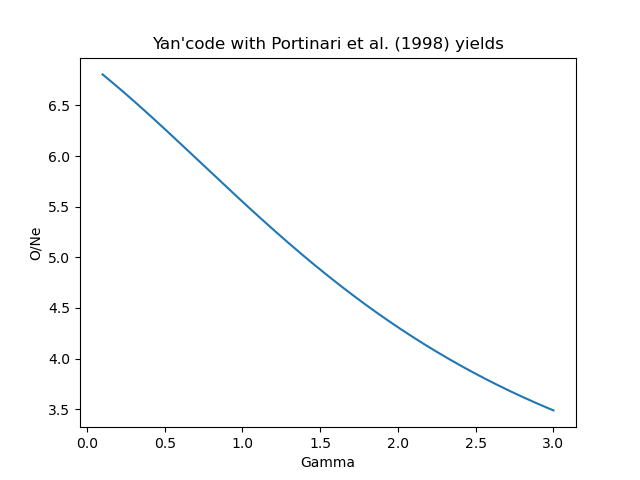

/var/folders/n1/b2jlktb513s_p91lxgjjcm440000gn/T/ipykernel_33893/1107513621.py:32: RuntimeWarning: invalid value encountered in divide
  ax.plot(x1, y1/y2/(O2Ne[solar_set]), '*', label='O/Ne')


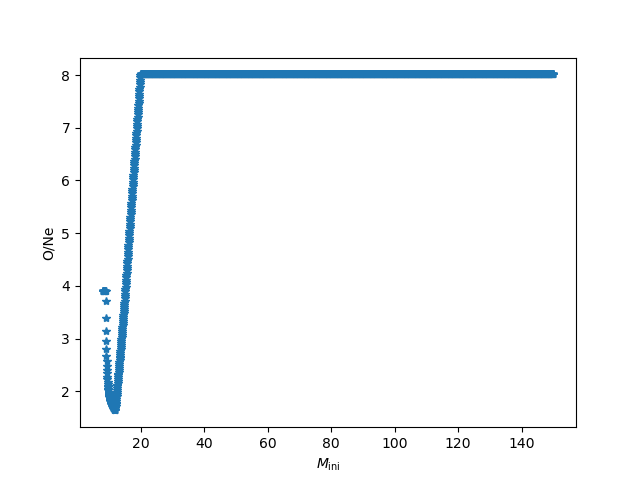

In [18]:
# Check Yan's model, yields from Portinari et al. (1998)
with open("../galIMF/yield_tables/rearranged___/setllar_O_eject_mass_from_portinari98/portinari98_Z=0.0004.txt", 'r') as f:
    lines = f.readlines()

x1 = np.array(lines[3].split()).astype(np.float64)
y1 = np.array(lines[5].split()).astype(np.float64)
interp1 = interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')

with open("../galIMF/yield_tables/rearranged___/setllar_Ne_eject_mass_from_portinari98/portinari98_Z=0.0004.txt", 'r') as f:
    lines = f.readlines()

x2 = np.array(lines[3].split()).astype(np.float64)
y2 = np.array(lines[5].split()).astype(np.float64)
interp2 = interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')

mass_bound = utils.lifetime_to_mass(13e9, 0.002)

Gammas = np.linspace(0.1, 3.0, 300)
Oxygen = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp1), full_output=1)[0] \
                   for Gamma in Gammas])
Neon = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp2), full_output=1)[0] \
                 for Gamma in Gammas])

fig, ax = plt.subplots()
ax.plot(Gammas, Oxygen/Neon/(O2Ne[solar_set]), label='O/Ne')
ax.set_xlabel('Gamma')
ax.set_ylabel('O/Ne')
ax.set_title("Yan'code with Portinari et al. (1998) yields")  # SNcc
plt.show()

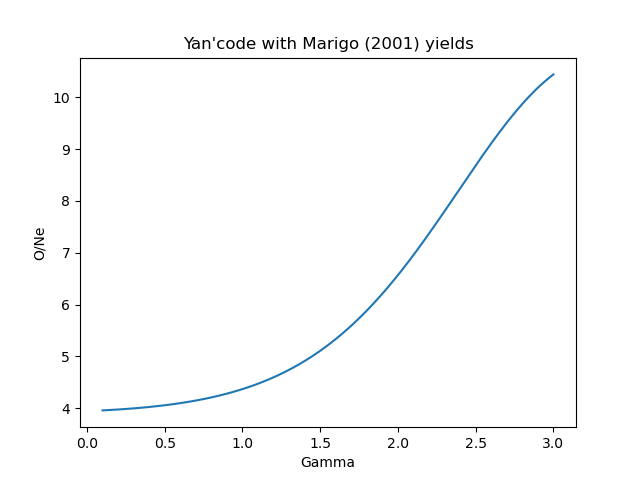

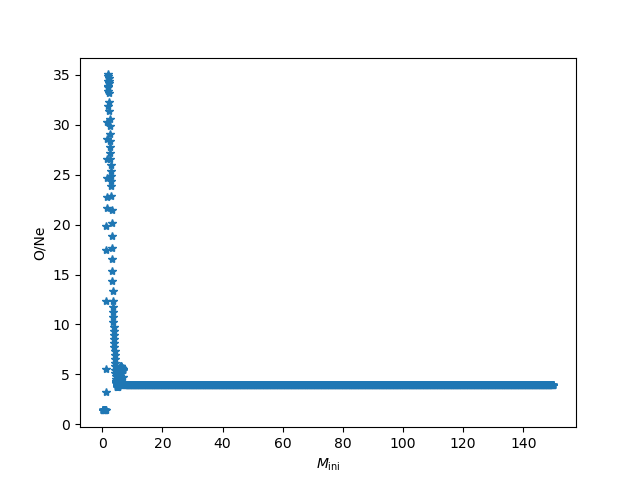

In [15]:
# Check Yan's model, yields from Marigo et al. (2001)
with open("../galIMF/yield_tables/rearranged___/setllar_O_eject_mass_from_marigo01/marigo01_Z=0.0004.txt", 'r') as f:
    lines = f.readlines()

x1 = np.array(lines[3].split()).astype(np.float64)
y1 = np.array(lines[5].split()).astype(np.float64)
interp1 = interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')

with open("../galIMF/yield_tables/rearranged___/setllar_Ne_eject_mass_from_marigo01/marigo01_Z=0.0004.txt", 'r') as f:
    lines = f.readlines()

x2 = np.array(lines[3].split()).astype(np.float64)
y2 = np.array(lines[5].split()).astype(np.float64)
interp2 = interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')

mass_bound = utils.lifetime_to_mass(13e9, 0.002)

Gammas = np.linspace(0.1, 3.0, 300)
Oxygen = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp1), full_output=1)[0] \
                   for Gamma in Gammas])
Neon = np.array([quad(PowerLaw, mass_bound, constants.Mstar_max, args=(Gamma, interp2), full_output=1)[0] \
                 for Gamma in Gammas])

fig, ax = plt.subplots()
ax.plot(Gammas, Oxygen/Neon/(O2Ne[solar_set]), label='O/Ne')
ax.set_xlabel('Gamma')
ax.set_ylabel('O/Ne')
ax.set_title("Yan'code with Marigo (2001) yields")  # AGB stars
plt.show()

In [1]:
import numpy as np

In [5]:
(np.log(1.4)/np.log(250)+1)

1.0609389872764843